In [1]:
#
# Imports
#

import os
import glob
import cv2
import random
import time
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import imageio
#imageio.plugins.ffmpeg.download()

from skimage.feature import hog
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from scipy.ndimage.measurements import label
from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# 
# Data loading and augmentation functions
#

def loadDataset():
    """
    Load the Auttie and crowdai datasets
    """
    datasets = [
        {
            'directory': 'object-dataset-autti',
            'names': ['frame', 'xmin', 'ymin', 'xmax', 'ymax', 'occluded', 'label', 'attributes'],
            'car_label': 'car',
            'sep': ' '
        },
        {
            'directory': 'object-detection-crowdai',
            'names': ['xmin', 'ymin', 'xmax', 'ymax', 'frame', 'label', 'preview'],
            'car_label': 'Car',
            'sep': None
        }
    ]

    for data in datasets:
        annotation_root = os.path.join('annotations', data['directory'])
        annotation_path = os.path.join(annotation_root, 'labels.csv')

        df = pd.read_csv(annotation_path, sep=data['sep'], header=None, names=data['names'])

        # filter out non-cars
        cars = df[df.label == data['car_label']]
        try:
            cars = cars.drop(['label', 'attributes', 'occluded'], 1)
        except ValueError:
            cars = cars.drop(['label', 'preview'], 1)

        cars = cars.groupby(['frame'], as_index = False)
        cars = cars.aggregate(lambda x : list(x))

        cars.reset_index()
        cars['frame'] = cars['frame'].apply(lambda x: os.path.join(annotation_root, x))

        yield cars

def carGenerator(sample_size=None):
    """
    Load all vehicle datasets and create a generator that returns one image at a time. 
    This is more robust than getCars() and should be used for augmenting data.
    """
    print('\033[1mLoading car dataset...\033[0m')

    # load GTI/KITTI datasets
    gti_df = pd.DataFrame(columns=['frame', 'xmin', 'ymin', 'xmax', 'ymax'])
    cars = glob.glob('annotations/vehicles/*/*.png')
    x_min = [[0]] * len(cars)
    y_min = [[0]] * len(cars)
    x_max = [[64]] * len(cars)
    y_max = [[64]] * len(cars)
    
    data = pd.DataFrame({'frame': cars, 'xmin': x_min, 'ymin': y_min, 'xmax': x_max, 'ymax': y_max})
    gti_df = gti_df.append(data)

    generator = loadDataset()
    autti_df = next(generator)
    crowdai_df = next(generator)

    cars_df = shuffle(pd.concat([gti_df, autti_df, crowdai_df]))
    print(cars_df.shape[0])
    
    # Reduce the sample size if necessary
    if sample_size:
        cars_df = cars_df[:sample_size]

    for i, row in cars_df.iterrows():
        filename = row['frame']
        img = mpimg.imread(filename)
        if np.max(img) <= 1:
            img = img * 255
            img = img.astype(np.uint8)

        for j in range(len(row['xmin'])):
            if row['ymin'][j] == row['ymax'][j] or row['xmin'][j] == row['xmax'][j]:
                continue

            # crop image to correct section and resize
            img_tosearch = img[
                int(row['ymin'][j]):int(row['ymax'][j]),
                int(row['xmin'][j]):int(row['xmax'][j]),
                :
            ]
            img_tosearch = cv2.resize(img_tosearch, (64, 64))
            yield img_tosearch

def notCarGenerator(sample_size=None):
    """
    Load all non-vehicle datasets and create a generator that returns one image at a time.
    This is more robust than getNotCars() and should be used for augmenting data.
    """
    print('\033[1mLoading non-car dataset...\033[0m')

    # load non-car dataset
    not_car_images = glob.glob('annotations/non-vehicles/*/*.png')
    hard_negatives = glob.glob('annotations/non-vehicles/hard-negative/*.jpg')
    not_cars = np.concatenate((not_car_images, hard_negatives))
    
    print(len(not_cars))

    if sample_size:
        not_cars = shuffle(not_cars)
        not_cars = not_cars[0:sample_size]

    # Functions for augmenting dataset
    basic_image = lambda image: image
    flip_image = lambda image: cv2.flip(image, 1)
    augmentation_funcs = [basic_image, flip_image]

    for filename in not_cars:
        img = mpimg.imread(filename)

        for func in augmentation_funcs:
            augmented_img = func(img)
            if np.max(augmented_img) <= 1:
                augmented_img = augmented_img * 255
                augmented_img = augmented_img.astype(np.uint8)

            yield augmented_img
            
def getCars(sample_size):
    """
    Return a list of vehicle image file names
    """
    cars = glob.glob('annotations/vehicles/*/*.png')
    print('{0} vehicle images found'.format(len(cars)))
    
    if sample_size:
            cars = shuffle(cars)[:sample_size]
    return cars

def getNotCars(sample_size, hard_neg=False):
    """
    Return a list of non-vehicle image file names
    """
    not_cars = glob.glob('annotations/non-vehicles/*/*.png')
    if hard_neg:
        hard_negatives = glob.glob('annotations/non-vehicles/hard-negative/*.jpg')
        not_cars = np.concatenate((not_cars, hard_negatives))
    print('{0} non-vehicle images found'.format(len(not_cars)))
        
    if sample_size:
            not_cars = shuffle(not_cars)[:sample_size]
    return not_cars

Loading car dataset...
30715
Loading non-car dataset...
9504


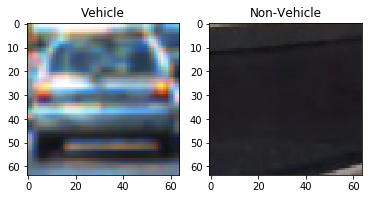

In [3]:
# Test data loading
car_generator = carGenerator(1)
car = next(car_generator)

not_car_generator = notCarGenerator(1)
not_car = next(not_car_generator)

fig = plt.figure()
plt.subplot(121)
plt.title('Vehicle')
plt.imshow(car)
plt.subplot(122)
plt.title('Non-Vehicle')
plt.imshow(not_car)

In [4]:
#
# Helper functions
#

def colorHist(img, nbins=32):
    """
    Return color histogram features of an image
    """
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    return hist_features

def binSpatial(img, size=(32, 32)):
    """
    Return spatial binning features of an image
    """
    features = cv2.resize(img, size).ravel()
    return features

def getHogFeatures(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """
    Return histogram of gradients (HOG) features of an image
    """
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def convertColor(img, conv='RGB2YCrCb'):
    """
    Convert an image between color spaces
    """
    if conv == 'RGB2YCrCb':
        converted_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif conv == 'RGB2LUV':
        converted_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif conv == 'RGB2HSV':
        converted_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif conv == 'RGB2HLS':
        converted_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif conv == 'RGB2YUV':
        converted_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

    if conv == 'BGR2YCrCb':
        converted_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif conv == 'BGR2LUV':
        converted_img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif conv == 'BGR2HSV':
        converted_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif conv == 'BGR2HLS':
        converted_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif conv == 'BGR2YUV':
        converted_img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        
    return converted_img

def extractFeatures(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9,
                    pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):
    """
    Extract features from a list of images image using color histograms, 
    spatial binning, and histograms of gradients
    """
    features = []
    for file in imgs:
        file_features = []
        
        image = mpimg.imread(file)
        if np.max(image) > 1:
            image = image.astype(np.float32)/255
        
        if color_space != 'RGB':
            feature_image = convertColor(image, color_space)
        else: 
            feature_image = np.copy(image)   
            
        if spatial_feat == True:
            spatial_features = binSpatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = colorHist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(getHogFeatures(feature_image[:,:,channel],
                                                       orient, pix_per_cell, cell_per_block,
                                                       vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = getHogFeatures(feature_image[:,:,hog_channel], orient,
                                              pix_per_cell, cell_per_block, vis=False, 
                                              feature_vec=True)
            file_features.append(hog_features)
            
        features.append(np.concatenate(file_features))
        
    return features

def singleImgFeatures(img, color_space='RGB', spatial_size=(32, 32),
                      hist_bins=32, orient=9, pix_per_cell=8, 
                      cell_per_block=2, hog_channel=0, spatial_feat=True, 
                      hist_feat=True, hog_feat=True, vis=False):
    """
    Extract the features from a single image using color histograms, spatial binning, 
    and histograms of gradients
    """
    img_features = []
    
    if color_space != 'RGB':
        feature_image = convertColor(img, color_space)
    else: 
        feature_image = np.copy(img)     
        
    if spatial_feat == True:
        spatial_features = binSpatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
        
    if hist_feat == True:
        hist_features = colorHist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
        
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(getHogFeatures(feature_image[:,:,channel],
                                                   orient, pix_per_cell, cell_per_block,
                                                   vis=False, feature_vec=True))      
        else:
            if vis:
                hog_features, hog_image = getHogFeatures(feature_image[:,:,hog_channel], orient,
                                                         pix_per_cell, cell_per_block, vis=vis,
                                                         feature_vec=True)
                img_features.append(hog_features)
                return np.concatenate(img_features), hog_image
            else:
                hog_features = getHogFeatures(feature_image[:,:,hog_channel], orient,
                                              pix_per_cell, cell_per_block, vis=vis,
                                              feature_vec=True)
                
        img_features.append(hog_features)

    return np.concatenate(img_features)

def slideWindow(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """
    Return a list of windows covering an area within an image
    """
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            window_list.append(((startx, starty), (endx, endy)))
            
    return window_list

def drawBoxes(img, bboxes, color=(0, 0, 255), thick=6):
    """
    Draw rectangles on an image
    """
    imcopy = np.copy(img)
    
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        
    return imcopy

def drawLabeledBoxes(img, labels):
    """
    Draw boxes on a labeled image
    """
    imcopy = np.copy(img)
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()

        # Identify x and y values of pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(imcopy, bbox[0], bbox[1], (0,0,255), 6)

    return imcopy

def addHeat(heatmap, bbox_list):
    """
    Create a heatmap by summing pixels contained within boxes
    """
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap

def applyThreshold(heatmap, threshold):
    """
    Apply a threshold to a heatmap
    """
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [5]:
#
# Classification model class
#

class Classifier(object):

    def __init__(self, color_space, orient, pixel_per_cell, cell_per_block, hog_channel, 
                 spatial_size, hist_bins, spatial_feat, hist_feat, hog_feat):
        self.sample_size = None

        self.color_space = color_space
        self.orient = orient
        self.pix_per_cell = pixel_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat

        self.scaler = StandardScaler(copy=False)
        self.svc = LinearSVC(C=0.001)

    def train(self, train, sample_size):
        """
        Train a support vector classifier or load one from disk
        """
        self.sample_size = sample_size
        
        if not os.path.exists('classifier.pkl') or train:
            # Train new classifier
            return self.__generateClassifier()
        else:
            # Load previously trained classifier
            X_test, y_test = self.__loadClassifier()

    def predict(self, features):
        """
        Make a prediction on new features
        """
        return self.svc.predict(features)
    
    def predict_prob(self, features):
        """
        Return the classification probability of new features
        """
        return self.svc.decision_function(features)

    def __storeClassifier(self, X_test, y_test):
        """
        Save a classifier to disk
        """
        joblib.dump((self.svc, self.scaler, X_test, y_test), 'classifier.pkl')

    def __loadClassifier(self):
        """
        Load a classifier from disk
        """
        loaded_data = joblib.load('classifier.pkl')
        self.svc = loaded_data[0]
        self.scaler = loaded_data[1]
        X_test = loaded_data[2]
        y_test = loaded_data[3]
        return (X_test, y_test)

    def __generateClassifier(self):
        """
        Train a new classifier and save it
        """
        cars = getCars(self.sample_size)
        not_cars = getNotCars(self.sample_size, hard_neg=True)
                
        print('\033[1mTraining classifier...\033[0m')
        t = time.time()
        # Extract features
        car_features = extractFeatures(cars, color_space=self.color_space,
                                       spatial_size=self.spatial_size, hist_bins=self.hist_bins,
                                       orient=self.orient, pix_per_cell=self.pix_per_cell,
                                       cell_per_block=self.cell_per_block,
                                       hog_channel=self.hog_channel, spatial_feat=self.spatial_feat,
                                       hist_feat=self.hist_feat, hog_feat=self.hog_feat)
        notcar_features = extractFeatures(not_cars, color_space=self.color_space,
                                          spatial_size=self.spatial_size, hist_bins=self.hist_bins,
                                          orient=self.orient, pix_per_cell=self.pix_per_cell,
                                          cell_per_block=self.cell_per_block,
                                          hog_channel=self.hog_channel, spatial_feat=self.spatial_feat,
                                          hist_feat=self.hist_feat, hog_feat=self.hog_feat)
        print('{0} seconds to compute features'.format(round(time.time()-t, 4)))

        # Concatenate all features and create labels
        X = np.vstack((car_features, notcar_features)).astype(np.float64)
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rand_state)

        # Perform column scaling
        self.scaler.fit(X_train)
        X_train = self.scaler.transform(X_train)
        X_test = self.scaler.transform(X_test)

        print('Using: {0} orientations {1} pixels per cell and {2} cells per block'.format(self.orient, 
                                                                                           self.pix_per_cell, 
                                                                                           self.cell_per_block))
        print('Feature vector length: {0}'.format(len(X_train[0])))

        t = time.time()
        self.svc.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')

        print('Test Accuracy of SVC = {0}'.format(round(self.svc.score(X_test, y_test), 4)))

        self.__storeClassifier(X_test, y_test)

        return (X_test, y_test)

In [11]:
#
# Vehicle detection class
#

class Detector(object):

    def __init__(self, train, mine_hard_neg, sample_size):
        self.x_start_stop = [0, 750]
        self.y_start_stop = [400, 656]
        self.scales = [1.0, 2.0, 3.0]
        self.xy_window = (256, 256)
        self.xy_overlap = (0.5, 0.5)

        self.color_space = 'RGB2YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient = 9  # HOG orientations
        self.pix_per_cell = 8 # HOG pixels per cell
        self.cell_per_block = 2 # HOG cells per block
        self.hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
        self.spatial_size = (32, 32) # Spatial binning dimensions
        self.hist_bins = 32    # Number of histogram bins
        self.spatial_feat = True # Spatial features on or off
        self.hist_feat = True # Histogram features on or off
        self.hog_feat = True # HOG features on or off
        self.y_start_stop = [400, 656] # Min and max in y to search in slide_window()
        
        self.confidence_thresh = 1
        self.heat_threshold = 1
        self.heatmaps_frames = 7
        self.heatmaps = deque(maxlen=self.heatmaps_frames)

        self.classifier = Classifier(
            self.color_space,
            self.orient,
            self.pix_per_cell,
            self.cell_per_block,
            self.hog_channel,
            self.spatial_size,
            self.hist_bins,
            self.spatial_feat,
            self.hist_feat,
            self.hog_feat,
        )
        self.classifier.train(train, sample_size)

    def processImage(self, img):
        """
        Vehicle detection pipeline
        """
        if not mine_hard_neg:
            _, hot_windows = self.find_cars(img)

            # Create heatmap
            heat = np.zeros_like(img[:,:,0]).astype(np.float)
            heat = addHeat(heat, hot_windows)
            heat = applyThreshold(heat, self.heat_threshold)
            self.heatmaps.append(heat)

            # Average heatmaps
            avg_heatmap = sum(self.heatmaps) / len(self.heatmaps)
            thresh_heatmap = applyThreshold(avg_heatmap, self.heat_threshold)
            thresh_heatmap = np.clip(thresh_heatmap, 0, 255)

            # Label and draw boxes
            labels = label(thresh_heatmap)
            boxes = drawLabeledBoxes(img, labels)
            
            return boxes
        else:
            # Perform hard negative mining in the specified region
            windows = slideWindow(img, self.x_start_stop, self.y_start_stop, self.xy_window, self.xy_overlap)
            
            img_num = 0
            for window in windows:
                sub_img = img[window[1][0]:window[1][1], window[0][0]:window[0][1],:]
                sub_img = cv2.resize(sub_img, (64, 64))
                
                time_stamp = time.strftime('%H%M%S')
                file_name = time_stamp + str(img_num)
                cv2.imwrite('annotations/non-vehicles/hard-negative/image_{0}.jpg'.format(file_name), sub_img)
                img_num += 1
                
            time.sleep(1)
            return img

    def find_cars(self, img):
        """
        Perform HOG subsampling and extract features using color histograms, 
        spatial binning, and histograms of gradients
        """
        draw_img = np.copy(img)
        img = img.astype(np.float32)/255

        img_tosearch = img[self.y_start_stop[0]:self.y_start_stop[1],:,:]
        ctrans_tosearch = convertColor(img_tosearch, conv='RGB2YCrCb')

        windows = []
        for scale in self.scales:
            if scale != 1:
                imshape = ctrans_tosearch.shape
                ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

            ch1 = ctrans_tosearch[:,:,0]
            ch2 = ctrans_tosearch[:,:,1]
            ch3 = ctrans_tosearch[:,:,2]

            # Define blocks and steps as above
            nxblocks = (ch1.shape[1] // self.pix_per_cell) - self.cell_per_block + 1
            nyblocks = (ch1.shape[0] // self.pix_per_cell) - self.cell_per_block + 1 
            nfeat_per_block = self.orient*self.cell_per_block**2

            # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
            window = 64
            nblocks_per_window = (window // self.pix_per_cell) - self.cell_per_block + 1
            cells_per_step = 2  # Instead of overlap, define how many cells to step
            nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
            nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

            # Compute individual channel HOG features for the entire image
            hog1 = getHogFeatures(ch1, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)
            hog2 = getHogFeatures(ch2, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)
            hog3 = getHogFeatures(ch3, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)

            for xb in range(nxsteps):
                for yb in range(nysteps):
                    ypos = yb*cells_per_step
                    xpos = xb*cells_per_step
                    # Extract HOG for this patch
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                    xleft = xpos*self.pix_per_cell
                    ytop = ypos*self.pix_per_cell

                    # Extract the image patch
                    subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                    # Get color features
                    spatial_features = binSpatial(subimg, size=self.spatial_size)
                    hist_features = colorHist(subimg, nbins=self.hist_bins)

                    # Scale features and make a prediction
                    test_features = self.classifier.scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                    prediction_prob = self.classifier.predict_prob(test_features)

                    if prediction_prob >= self.confidence_thresh:
                        xbox_left = np.int(xleft*scale)
                        ytop_draw = np.int(ytop*scale)
                        win_draw = np.int(window*scale)
                        windows.append(((xbox_left, ytop_draw+self.y_start_stop[0]), 
                                        (xbox_left+win_draw,ytop_draw+win_draw+self.y_start_stop[0])))
                        cv2.rectangle(draw_img,
                                      (xbox_left, ytop_draw+self.y_start_stop[0]),
                                      (xbox_left+win_draw,ytop_draw+win_draw+self.y_start_stop[0]),
                                      (0,0,255),6) 

        return draw_img, windows

In [20]:
train = False
mine_hard_neg = False
sample_size = None

detector = Detector(train, mine_hard_neg, sample_size)
# img = mpimg.imread('test_images/test1.jpg')
# boxes = detector.processImage(img)
# plt.imshow(boxes)

if not train:
    processed_output = 'output_images/output_video.mp4'
    clip = VideoFileClip('project_video.mp4')
    processed_clip = clip.fl_image(detector.processImage)
    %time processed_clip.write_videofile(processed_output, audio=False)

[MoviePy] >>>> Building video output_images/output_video.mp4
[MoviePy] Writing video output_images/output_video.mp4



 12%|█▏        | 152/1261 [04:59<36:23,  1.97s/it]


 24%|██▍       | 303/1261 [10:03<31:49,  1.99s/it]


 36%|███▌      | 454/1261 [15:10<26:58,  2.01s/it]


 48%|████▊     | 605/1261 [20:14<21:57,  2.01s/it]


 60%|█████▉    | 756/1261 [25:19<16:54,  2.01s/it]


 72%|███████▏  | 907/1261 [30:23<11:51,  2.01s/it]


 84%|████████▍ | 1057/1261 [35:22<06:49,  2.01s/it]


 96%|█████████▌| 1205/1261 [40:12<01:52,  2.00s/it]


100%|█████████▉| 1260/1261 [41:59<00:01,  2.00s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/output_video.mp4 

CPU times: user 37min 44s, sys: 1min, total: 38min 44s
Wall time: 42min


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>\
""".format(processed_output))